In [1]:
import torch
import torchvision
from torch import nn
from torch.utils.data import Dataset, DataLoader
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

In [6]:
model = torchvision.models.vit_b_32(weights=torchvision.models.ViT_B_32_Weights.DEFAULT)
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model.heads = nn.Sequential(nn.Linear(768, 256), 
                            nn.GELU(),
                            nn.BatchNorm1d(256),
                            nn.Linear(256, 1))
model = model.to(device)

In [7]:
class force_db(Dataset):

    def __init__(self, img_path, force_path, fingers_path, transforms=torchvision.models.ViT_B_32_Weights.IMAGENET1K_V1.transforms(), padding=20, upper=-1, lower=0):
        img_paths = os.listdir(img_path)
        img_paths.sort(key=lambda x: int(os.path.splitext(os.path.basename(x))[0]))
        force_paths = os.listdir(force_path)
        force_paths.sort(key=lambda x: int((os.path.basename(x)).split(".")[0].split("_")[1]))
        finger_paths = os.listdir(fingers_path)
        finger_paths.sort(key= lambda x: int(os.path.splitext(os.path.basename(x))[0]))

        self.img_paths = [os.path.join(img_path, path) for path in img_paths][lower:upper]
        self.force_paths = [os.path.join(force_path, path) for path in force_paths][lower:upper]
        self.finger_paths = [os.path.join(fingers_path, path) for path in finger_paths][lower:upper]

        self.force_arrs = [np.load(path).astype(np.float16) for path in tqdm(self.force_paths)]
        self.img_arrs = [cv2.imread(path).astype(np.float16) for path in self.img_paths]
        self.finger_idxs = [np.load(path).astype(np.float16) for path in self.finger_paths]

        self.padding = padding
        self.transforms = transforms
    
    def __getitem__(self, index):
        force_arr = self.force_arrs[index]
        img = self.img_arrs[index]
        finger_idxs = self.finger_idxs[index].astype(int)[:, ::-1]

        force_vals = np.sort(np.unique(force_arr))

        if len(force_vals) <= 1:
            finger = 1#np.random.randint(0, len(finger_idxs))
            x_min, y_min = finger_idxs[finger] - self.padding - 80
            x_max, y_max = finger_idxs[finger] + self.padding + 80
            x_min, y_min = max(x_min,0), max(y_min,0)
            x_max, y_max = min(x_max, img.shape[0]) , min(y_max, img.shape[1])
            # print(finger_idxs[finger])
            # print(img[x_min:x_max, y_min:y_max].shape)

            return self.transforms(torch.tensor(img[x_min:x_max, y_min:y_max].transpose(2, 0, 1))), np.float32(0.0)
        
        finger = 1#np.random.randint(1, len(np.unique(force_arr)))
        indices = np.argwhere(force_arr == force_vals[finger])
        
        x_min, y_min, _ = indices.min(axis=0) - self.padding
        x_max, y_max, _ = indices.max(axis=0) + self.padding
        x_min, y_min = max(x_min,0), max(y_min,0)
        x_max, y_max = min(x_max, img.shape[0]) , min(y_max, img.shape[1])

        return self.transforms(torch.tensor(img[x_min:x_max, y_min:y_max].transpose(2, 0, 1))), np.float32(1.0)
    
    def get_original(self, index):
        force_arr = self.force_arrs[index]
        img = self.img_arrs[index]
        finger_idxs = self.finger_idxs[index].astype(int)[:, ::-1]

        force_vals = np.unique(force_arr)

        if len(force_vals) <= 1:
            finger = np.random.choice(len(finger_idxs))
            # finger = 1
            x_min, y_min = finger_idxs[finger] - self.padding - 80
            x_max, y_max = finger_idxs[finger] + self.padding + 80
            x_min, y_min = max(x_min,0), max(y_min,0)
            x_max, y_max = min(x_max, img.shape[0]) , min(y_max, img.shape[1])
            # print(finger_idxs[finger])
            # print(img[x_min:x_max, y_min:y_max].shape)

            return img[x_min:x_max, y_min:y_max], img, finger_idxs, np.float32(0.0)
        
        finger = np.random.randint(1, len(np.unique(force_arr)))
        # finger = 1
        indices = np.argwhere(force_arr == force_vals[finger])
        
        x_min, y_min, _ = indices.min(axis=0) - self.padding
        x_max, y_max, _ = indices.max(axis=0) + self.padding
        x_min, y_min = max(x_min,0), max(y_min,0)
        x_max, y_max = min(x_max, img.shape[0]) , min(y_max, img.shape[1])

        return img[x_min:x_max, y_min:y_max], img, finger_idxs, np.float32(1.0)

    def __len__(self):
        return len(self.finger_idxs)

In [4]:
# train_dataset = force_db("finger_force_db/original_img", "finger_force_db/finger_force", "finger_force_db/finger_joints",upper=2300)
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataset = force_db("finger_force_db/original_img", "finger_force_db/finger_force", "finger_force_db/finger_joints",lower=2300, upper=3100)
val_loader = DataLoader(val_dataset, batch_size=32)

  0%|          | 0/422 [00:00<?, ?it/s]

100%|██████████| 422/422 [00:09<00:00, 45.57it/s]


In [7]:
padding = 20
img = np.zeros((1080, 1920))
for i in tqdm(range(len(train_dataset))):
    for finger_idx in train_dataset.finger_idxs[i].astype(int)[:, ::-1]:
        x_min, y_min = finger_idx - padding - 80
        x_max, y_max = finger_idx + padding + 80    
        x_min, y_min = max(x_min,0), max(y_min,0)
        x_max, y_max = min(x_max, img.shape[0]) , min(y_max, img.shape[1])

        if x_max <= x_min or y_max <= y_min:
            print(f"Error: data {i}")

100%|██████████| 2300/2300 [00:00<00:00, 50285.12it/s]


In [8]:
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [9]:
model.load_state_dict(torch.load("touch_vit_models/model_weights2.1_complete.pth"))

/tmp/ipykernel_1368511/2727681702.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("touch_vit_models/model_weights2.1_complete.pth"))


<All keys matched successfully>

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [11]:
epochs = 1
for epoch in range(epochs):
    model.train()  
    epoch_loss = 0

    # for inputs, targets in tqdm(val_loader):
    #     inputs = inputs.to(device)
    #     targets = targets.to(device)

    #     outputs = model(inputs)
    #     pred = torch.sigmoid(outputs)
    #     loss = loss_fn(pred.flatten(), torch.tensor(targets, dtype=torch.float32))

    #     # Backward pass and optimization
    #     optimizer.zero_grad()
    #     loss.backward()
    #     optimizer.step()

    #     epoch_loss += loss.item()

    # # Print epoch loss
    # print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {epoch_loss / len(train_dataset)}")

    model.eval()
    val_loss = 0
    val_acc = 0
    matrix = np.zeros((2,2))
    for inputs, targets in tqdm(val_loader):
        inputs = inputs.to(device)
        targets = targets.to(device)

        outputs = model(inputs)
        pred = torch.round(torch.sigmoid(outputs))
        loss = loss_fn(outputs.flatten(), targets)
        matrix += confusion_matrix(pred.flatten().detach().cpu().numpy(), targets.detach().cpu().numpy())
        val_acc += (pred.flatten() == targets).sum()
        val_loss += loss.item()
    
    print(f"Epoch {epoch + 1}/{epochs}, Val Loss: {val_loss / len(val_dataset)}, Val Acc: {val_acc / len(val_dataset)}")

 79%|███████▊  | 11/14 [01:53<00:17,  5.95s/it]/home/brianchen/anaconda3/envs/wilor/lib/python3.10/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
100%|██████████| 14/14 [02:05<00:00,  8.98s/it]

Epoch 1/1, Val Loss: 0.014947433633756299, Val Acc: 0.8412322402000427


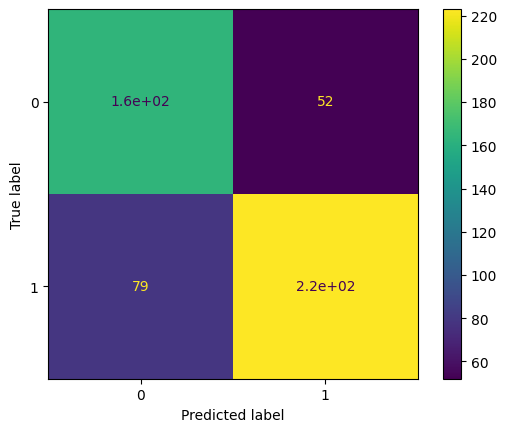

In [12]:
disp = ConfusionMatrixDisplay(matrix)
disp.plot()
plt.show()

In [12]:
targets

tensor([1., 1., 1., 0., 0., 0.], device='cuda:1')

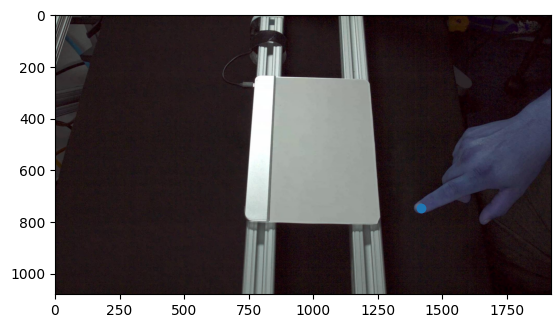

In [29]:
plt.scatter(fingers[1, 0], fingers[1, 1])
plt.imshow(cv2.imread("finger_force_db/original_img/11.jpg"))

In [227]:
transform = torchvision.models.ViT_B_32_Weights.IMAGENET1K_V1.transforms()

In [228]:
transform(inputs)

tensor([[[[  2.2857,   2.7391,   3.0429,  ...,  -8.8332,  -8.8014,  -9.1326],
          [  2.2904,   2.6944,   3.0286,  ...,  -9.0759,  -9.0015,  -9.3172],
          [  2.2422,   2.6316,   2.9728,  ...,  -9.1758,  -9.1496,  -9.2410],
          ...,
          [  7.7027,   7.7027,   7.7027,  ...,  -3.1359,  -3.1359,  -3.1359],
          [  7.7027,   7.7027,   7.7027,  ...,  -3.3041,  -3.3041,  -3.3041],
          [  7.7027,   7.7027,   7.7027,  ...,  -3.3555,  -3.3555,  -3.3555]],

         [[  3.9214,   4.4001,   4.8250,  ...,  -9.7545,  -9.7578, -10.0491],
          [  3.9262,   4.4565,   4.8498,  ...,  -9.9611,  -9.9541, -10.1739],
          [  3.9296,   4.3811,   4.7838,  ..., -10.0387, -10.0625, -10.0762],
          ...,
          [  8.8061,   8.8061,   8.8061,  ...,  -0.8022,  -0.8022,  -0.8022],
          [  8.8061,   8.8061,   8.8061,  ...,  -0.9781,  -0.9781,  -0.9781],
          [  8.8061,   8.8061,   8.8061,  ...,  -1.0382,  -1.0416,  -1.0416]],

         [[  5.0194,   5.5483,